In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
seed = 7
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


<ipython-input-2-963e9fe246f8>:22: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print(jax.tree_map(lambda x: x.shape, MLP_params))


In [3]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

In [4]:
# Custom transformation function
def custom_transform(x, y):
    x = np.ravel(np.array(x, dtype=np.float32))  # Flatten the image
    return x, y

# Load MNIST using TensorFlow
(train_images, train_lbls), (test_images, test_lbls) = tf.keras.datasets.mnist.load_data()

# Convert labels to int32
train_lbls = np.array(train_lbls, dtype=np.int32)
test_lbls = np.array(test_lbls, dtype=np.int32)

# Create TensorFlow Datasets
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_lbls))
train_dataset = train_dataset.map(lambda x, y: tf.py_function(custom_transform, [x, y], [tf.float32, tf.int32]))
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_lbls))
test_dataset = test_dataset.map(lambda x, y: tf.py_function(custom_transform, [x, y], [tf.float32, tf.int32]))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Convert TensorFlow Dataset to JAX arrays
def tf_to_jax(dataset):
    images, labels = [], []
    for x, y in dataset.unbatch():
        images.append(x.numpy())
        labels.append(y.numpy())
    return jnp.array(images), jnp.array(labels)

# Convert the entire dataset to JAX format
train_images_jax, train_lbls_jax = tf_to_jax(train_dataset)
test_images_jax, test_lbls_jax = tf_to_jax(test_dataset)

# Test Shapes
print(f"Train Images Shape: {train_images_jax.shape}, Labels Shape: {train_lbls_jax.shape}")
print(f"Test Images Shape: {test_images_jax.shape}, Labels Shape: {test_lbls_jax.shape}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train Images Shape: (60000, 784), Labels Shape: (60000,)
Test Images Shape: (10000, 784), Labels Shape: (10000,)


In [6]:
# Vectorized Version of MLP
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

# --------------- LOSS FUNCTION & ACCURACY ---------------- #

# Loss function: Cross-entropy loss
def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)
    return -jnp.mean(jnp.sum(predictions * gt_lbls, axis=1))

# Accuracy function
def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

# -------------- OPTIMIZATION (JIT + GRADIENT DESCENT) -------------- #

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)
    new_params = jax.tree_map(lambda p, g: p - lr * g, params, grads)
    return loss, new_params

num_epochs = 5
key = jax.random.PRNGKey(0)  # Random Seed
MLP_params = init_MLP([784, 512, 256, 10], key)  # Model Initialization

for epoch in range(num_epochs):
    for cnt, (imgs, lbls) in enumerate(train_dataset):
        imgs = jnp.array(imgs.numpy())  # Convert TF Tensor to JAX Array
        lbls = jnp.array(lbls.numpy())

        gt_labels = jax.nn.one_hot(lbls, 10)  # One-hot encode labels

        loss, MLP_params = update(MLP_params, imgs, gt_labels)

        if cnt % 50 == 0:
            print(f"Epoch {epoch} Step {cnt} Loss: {loss}")

    train_acc = accuracy(MLP_params, train_images_jax, train_lbls_jax)
    test_acc = accuracy(MLP_params, test_images_jax, test_lbls_jax)

    print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")


Epoch 0 Step 0 Loss: 2.3777148723602295
Epoch 0 Step 50 Loss: 0.740364134311676
Epoch 0 Step 100 Loss: 0.17937028408050537
Epoch 0 Step 150 Loss: 0.346528023481369
Epoch 0 Step 200 Loss: 0.16743624210357666
Epoch 0 Step 250 Loss: 0.19705228507518768
Epoch 0 Step 300 Loss: 0.16798755526542664
Epoch 0 Step 350 Loss: 0.13755151629447937
Epoch 0 Step 400 Loss: 0.1477997601032257
Epoch 0 Step 450 Loss: 0.15869536995887756
Epoch 0: Train Acc = 0.9627, Test Acc = 0.9603
Epoch 1 Step 0 Loss: 0.09841696918010712
Epoch 1 Step 50 Loss: 0.07641023397445679
Epoch 1 Step 100 Loss: 0.105646513402462
Epoch 1 Step 150 Loss: 0.16646048426628113
Epoch 1 Step 200 Loss: 0.12523914873600006
Epoch 1 Step 250 Loss: 0.11378362029790878
Epoch 1 Step 300 Loss: 0.13574588298797607
Epoch 1 Step 350 Loss: 0.12143296748399734
Epoch 1 Step 400 Loss: 0.0341273657977581
Epoch 1 Step 450 Loss: 0.0572860911488533
Epoch 1: Train Acc = 0.9796, Test Acc = 0.9696
Epoch 2 Step 0 Loss: 0.1339586079120636
Epoch 2 Step 50 Loss: 

Predicted Label: 7
Ground Truth Label: 7


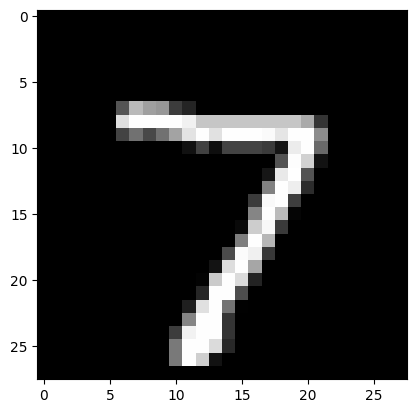

In [9]:
import matplotlib.pyplot as plt

# Get one batch from test_dataset
test_batch = next(iter(test_dataset))
imgs, lbls = test_batch  # Unpack images and labels
imgs = jnp.array(imgs.numpy())  # Convert TensorFlow Tensors to JAX arrays
lbls = jnp.array(lbls.numpy())

# Extract a single image and label
img = imgs[0].reshape((28, 28))  # Reshape to MNIST format
gt_lbl = lbls[0]

# Predict using JAX MLP
pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))

# Print predictions
print('Predicted Label:', pred)
print('Ground Truth Label:', gt_lbl)

# Show the image
plt.imshow(img, cmap='gray')
plt.show()

(512, 784)
(28, 28)


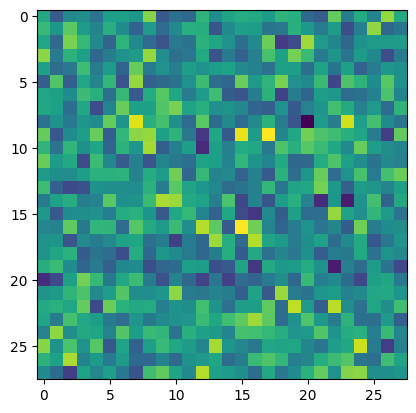

In [10]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()